# Markov Regime-Switching Volatility Rolling VaR Backtesting (2-State)

This notebook runs the same rolling 1-day VaR/ES backtest framework as the GBM baseline,
but upgrades the volatility model to allow **switching between two regimes**:

- **Regime 0:** low volatility (calm market)
- **Regime 1:** high volatility (stressed market)

A **discrete-time Markov chain** governs how the regime changes day-to-day, capturing
volatility clustering (quiet periods followed by quiet periods, stressed periods followed by stressed periods).

**Inputs**
Assumes `01_data_features.ipynb` already created:
- `data/processed/prices_returns.parquet`

**Outputs saved to Drive**
- `outputs/tables/rs_backtest_results.csv`
- `outputs/tables/rs_scorecard.csv`
- `outputs/figures/*` diagnostic plots (realized loss vs VaR, cumulative breaches)

**Why this notebook exists**
Financial returns often show volatility clustering that a constant-volatility GBM misses.
Regime-switching volatility is a minimal, course-aligned extension (Markov chains) to better reflect that pattern,
then we evaluate it using the same backtesting logic.


In [1]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


In [2]:
from pathlib import Path

PROJECT_NAME = "equity_var_backtesting"
BASE = Path("/content/drive/MyDrive") / PROJECT_NAME

DIRS = {
    "data_processed": BASE / "data" / "processed",
    "tables": BASE / "outputs" / "tables",
    "figures": BASE / "outputs" / "figures",
}

for p in DIRS.values():
    p.mkdir(parents=True, exist_ok=True)

DATA_PATH = DIRS["data_processed"] / "prices_returns.parquet"
DATA_PATH


PosixPath('/content/drive/MyDrive/equity_var_backtesting/data/processed/prices_returns.parquet')

In [3]:
!pip -q install pandas numpy pyarrow matplotlib


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
plt.rcParams["figure.figsize"] = (12, 5)

TRADING_DAYS = 252
SEED = 42

WINDOW = 252          # rolling estimation window
N_PATHS = 10000       # dev: 5k–10k; final: 20k+
VAR_LEVELS = [0.95, 0.99]

# Regime labeling settings
VOL_WINDOW = 20                # rolling vol lookback (days)
HIGH_VOL_PERCENTILE = 0.70     # top 30% vol days labeled as high-vol regime (1)


In [5]:
df = pd.read_parquet(DATA_PATH)
df["date"] = pd.to_datetime(df["date"])
df.head()


,date,ticker,price,log_return,realized_vol_20d
0,2015-01-02,AAPL,24.237551,NaN,NaN
1,2015-01-05,AAPL,23.554741,-0.028576,NaN
2,2015-01-06,AAPL,23.556965,0.000094,NaN
3,2015-01-07,AAPL,23.887274,0.013924,NaN
4,2015-01-08,AAPL,24.805077,0.037702,NaN


In [6]:
#Wide log return matrix (date × ticker)
logret = df.pivot(index="date", columns="ticker", values="log_return").sort_index()
logret = logret.dropna(how="all")

TICKERS = sorted(logret.columns.tolist())
TICKERS


['AAPL', 'JPM', 'MSFT', 'SPY', 'TSLA', 'XOM']

In [7]:
#Computing realized vol (needed for regime labeling)
realized_vol = logret.rolling(VOL_WINDOW).std() * np.sqrt(TRADING_DAYS)
realized_vol.tail()


ticker,AAPL,JPM,MSFT,SPY,TSLA,XOM
date,,,,,,
2025-12-15,0.162420,0.273087,0.226621,0.120561,0.364760,0.168792
2025-12-16,0.146725,0.275499,0.227769,0.115450,0.373045,0.187153
2025-12-17,0.152238,0.275163,0.208938,0.118631,0.412682,0.202384
2025-12-18,0.151736,0.274060,0.213392,0.120561,0.423051,0.197752
2025-12-19,0.148467,0.268607,0.205308,0.106879,0.410511,0.197608


In [8]:
#VaR/ES from simulated returns
def var_es_from_returns(simple_returns: np.ndarray, alpha=0.95):
    R = np.asarray(simple_returns)
    L = -R
    VaR = np.quantile(L, alpha)
    ES = L[L >= VaR].mean()
    return float(VaR), float(ES)


In [9]:
#Estimating 2×2 Markov transition matrix
def estimate_transition_matrix(states: np.ndarray):
    """
    states: array of 0/1 regime labels
    Returns:
      P: 2x2 transition matrix where P[i,j] = P(state_{t+1}=j | state_t=i)
    """
    s = np.asarray(states).astype(int)
    s = s[~np.isnan(s)]

    # count transitions
    counts = np.zeros((2, 2), dtype=float)
    for t in range(len(s) - 1):
        i, j = s[t], s[t+1]
        if i in (0, 1) and j in (0, 1):
            counts[i, j] += 1

    # normalize rows; handle zero-row edge case
    P = np.zeros((2, 2), dtype=float)
    for i in (0, 1):
        row_sum = counts[i].sum()
        if row_sum == 0:
            P[i] = np.array([0.5, 0.5])  # fallback
        else:
            P[i] = counts[i] / row_sum

    return P, counts


In [10]:
#buildin regimes from rolling vol
def label_regimes_from_vol(vol_series: pd.Series, high_vol_percentile=0.70):
    """
    Regime = 1 if vol > percentile threshold, else 0.
    """
    v = vol_series.dropna()
    if len(v) < 30:
        # not enough vol history; return empty
        return pd.Series(index=vol_series.index, dtype="float64")

    thresh = np.nanpercentile(v.values, high_vol_percentile * 100)
    regime = (vol_series > thresh).astype(int)
    return regime, float(thresh)


In [11]:
# Calibrating: per-regime sigma + transition matrix (rolling window)
def calibrate_regime_switching(logret_window: np.ndarray,
                               vol_window_series: np.ndarray,
                               trading_days=252,
                               high_vol_percentile=0.70):
    """
    From a rolling window:
    1) compute realized vol series for regime labeling (already computed outside)
    2) label regimes (0/1) based on vol percentile
    3) estimate transition matrix P
    4) estimate sigma_low, sigma_high from returns in each regime
    5) estimate mu from overall window mean (simple)

    Returns annualized mu and annualized sigma for each regime + P.
    """
    r = np.asarray(logret_window)
    v = np.asarray(vol_window_series)

    # drop nans aligned (keep positions where both exist)
    mask = ~np.isnan(r) & ~np.isnan(v)
    r = r[mask]
    v = v[mask]

    if len(r) < 60:
        raise ValueError("Not enough data for regime calibration window.")

    # label regimes using vol percentile threshold inside the window
    thresh = np.nanpercentile(v, high_vol_percentile * 100)
    states = (v > thresh).astype(int)

    # transition matrix
    P, counts = estimate_transition_matrix(states)

    # mu (annualized) from all returns
    mu_daily = r.mean()
    mu_annual = mu_daily * trading_days

    # sigma per regime (annualized)
    r_low = r[states == 0]
    r_high = r[states == 1]

    # fallbacks if a regime is empty
    sig_daily_all = r.std(ddof=1)
    sig_low_daily = r_low.std(ddof=1) if len(r_low) >= 2 else sig_daily_all
    sig_high_daily = r_high.std(ddof=1) if len(r_high) >= 2 else sig_daily_all

    sigma_low_annual = sig_low_daily * np.sqrt(trading_days)
    sigma_high_annual = sig_high_daily * np.sqrt(trading_days)

    # current (last) state in window
    current_state = int(states[-1])

    return {
        "mu_annual": float(mu_annual),
        "sigma_low_annual": float(sigma_low_annual),
        "sigma_high_annual": float(sigma_high_annual),
        "P00": float(P[0,0]),
        "P01": float(P[0,1]),
        "P10": float(P[1,0]),
        "P11": float(P[1,1]),
        "vol_threshold": float(thresh),
        "current_state": current_state,
        "n_low": int((states == 0).sum()),
        "n_high": int((states == 1).sum())
    }


In [12]:
# Next-day returns with regime switching simulation
#How simulation works: start from today’s regime (current_state), draw tomorrow’s regime based on transition probabilities, use that regime’s volatility to generate tomorrow return (GBM step)
def simulate_regime_switching_1d_returns(params: dict,
                                        n_paths=10000,
                                        seed=42,
                                        trading_days=252):
    rng = np.random.default_rng(seed)
    dt = 1 / trading_days

    mu = params["mu_annual"]
    sig_low = params["sigma_low_annual"]
    sig_high = params["sigma_high_annual"]

    P = np.array([
        [params["P00"], params["P01"]],
        [params["P10"], params["P11"]],
    ], dtype=float)

    s0 = int(params["current_state"])

    # sample tomorrow state for each path using transition row from s0
    probs = P[s0]
    states_tomorrow = rng.choice([0, 1], size=n_paths, p=probs)

    sigma_t = np.where(states_tomorrow == 0, sig_low, sig_high)

    Z = rng.standard_normal(n_paths)
    log_r = (mu - 0.5 * sigma_t**2) * dt + sigma_t * np.sqrt(dt) * Z

    return np.exp(log_r) - 1.0, states_tomorrow


In [13]:
#Rolling backtest (Regime Switching)
def backtest_regime_switching_single_ticker(logret_series: pd.Series,
                                            realized_vol_series: pd.Series,
                                            window=252,
                                            var_levels=(0.95, 0.99),
                                            n_paths=10000,
                                            seed=42,
                                            trading_days=252,
                                            high_vol_percentile=0.70):
    r = logret_series.dropna().copy()
    # align vol to returns index
    v = realized_vol_series.reindex(r.index)

    dates = r.index
    rng = np.random.default_rng(seed)
    rows = []

    for i in range(window, len(r) - 1):
        train_r = r.iloc[i-window:i].values
        train_v = v.iloc[i-window:i].values
        realized_log = float(r.iloc[i+1])

        params = calibrate_regime_switching(
            logret_window=train_r,
            vol_window_series=train_v,
            trading_days=trading_days,
            high_vol_percentile=high_vol_percentile
        )

        day_seed = int(rng.integers(1, 1_000_000))
        sim_R, sim_states = simulate_regime_switching_1d_returns(
            params,
            n_paths=n_paths,
            seed=day_seed,
            trading_days=trading_days
        )

        realized_simple = np.exp(realized_log) - 1.0
        realized_loss = -realized_simple

        out = {
            "date": dates[i+1],
            "realized_logret": realized_log,
            "realized_simple_return": realized_simple,
            "realized_loss": realized_loss,

            # parameters for transparency
            "mu_annual": params["mu_annual"],
            "sigma_low_annual": params["sigma_low_annual"],
            "sigma_high_annual": params["sigma_high_annual"],
            "P00": params["P00"], "P01": params["P01"],
            "P10": params["P10"], "P11": params["P11"],
            "vol_threshold": params["vol_threshold"],
            "current_state": params["current_state"],
            "n_low": params["n_low"],
            "n_high": params["n_high"],

            # simulation diagnostics
            "sim_high_state_frac": float((sim_states == 1).mean())
        }

        for a in var_levels:
            lvl = int(a * 100)
            VaR, ES = var_es_from_returns(sim_R, alpha=a)
            out[f"VaR_{lvl}"] = VaR
            out[f"ES_{lvl}"] = ES
            out[f"breach_{lvl}"] = bool(realized_loss > VaR)

        rows.append(out)

    return pd.DataFrame(rows)


In [14]:
#Regime-switching backtest for all tickers
bt_list = []
for tkr in TICKERS:
    series_r = logret[tkr]
    series_v = realized_vol[tkr]

    bt = backtest_regime_switching_single_ticker(
        logret_series=series_r,
        realized_vol_series=series_v,
        window=WINDOW,
        var_levels=VAR_LEVELS,
        n_paths=N_PATHS,
        seed=SEED,
        trading_days=TRADING_DAYS,
        high_vol_percentile=HIGH_VOL_PERCENTILE
    )
    bt["ticker"] = tkr
    bt["model"] = "RegimeSwitchVol"
    bt_list.append(bt)

rs_all = pd.concat(bt_list, ignore_index=True).sort_values(["ticker", "date"])
rs_all.head()


,date,realized_logret,realized_simple_return,realized_loss,mu_annual,sigma_low_annual,sigma_high_annual,P00,P01,P10,P11,vol_threshold,current_state,n_low,n_high,sim_high_state_frac,VaR_95,ES_95,breach_95,VaR_99,ES_99,breach_99,ticker,model
0,2016-01-06,-0.019763,-0.019569,0.019569,-0.096644,0.213334,0.336816,0.975309,0.024691,0.071429,0.928571,0.270407,0,163,70,0.0264,0.022506,0.028255,False,0.031921,0.036978,False,AAPL,RegimeSwitchVol
1,2016-01-07,-0.043121,-0.042205,0.042205,-0.123562,0.214892,0.336816,0.975460,0.024540,0.071429,0.928571,0.270392,0,164,70,0.0253,0.022598,0.027975,True,0.031166,0.036153,True,AAPL,RegimeSwitchVol
2,2016-01-08,0.005274,0.005288,-0.005288,-0.144230,0.216133,0.334518,0.975460,0.024540,0.070423,0.929577,0.270173,0,164,71,0.0242,0.023031,0.028710,False,0.032301,0.037507,False,AAPL,RegimeSwitchVol
3,2016-01-11,0.016062,0.016192,-0.016192,-0.189663,0.221729,0.334518,0.975610,0.024390,0.070423,0.929577,0.269853,0,165,71,0.0242,0.024315,0.030394,False,0.033910,0.039561,False,AAPL,RegimeSwitchVol
4,2016-01-12,0.014409,0.014513,-0.014513,-0.183255,0.221194,0.334518,0.975758,0.024242,0.070423,0.929577,0.269532,0,166,71,0.0261,0.023317,0.029324,False,0.033097,0.036896,False,AAPL,RegimeSwitchVol


In [15]:
out_rs = DIRS["tables"] / "rs_backtest_results.csv"
rs_all.to_csv(out_rs, index=False)
print("Saved:", out_rs)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/rs_backtest_results.csv


In [16]:
#Scorecard: breach rate vs expected
score_rows = []
for tkr in TICKERS:
    sub = rs_all[rs_all["ticker"] == tkr]
    n = len(sub)
    for a in VAR_LEVELS:
        lvl = int(a * 100)
        col = f"breach_{lvl}"
        score_rows.append({
            "ticker": tkr,
            "model": "RegimeSwitchVol",
            "var_level": a,
            "n_obs": n,
            "breaches": int(sub[col].sum()),
            "breach_rate": float(sub[col].mean()),
            "expected_rate": 1 - a
        })

rs_score = pd.DataFrame(score_rows).sort_values(["ticker", "var_level"])
display(rs_score)


,ticker,model,var_level,n_obs,breaches,breach_rate,expected_rate
0,AAPL,RegimeSwitchVol,0.95,2505,130,0.051896,0.05
1,AAPL,RegimeSwitchVol,0.99,2505,55,0.021956,0.01
2,JPM,RegimeSwitchVol,0.95,2505,120,0.047904,0.05
3,JPM,RegimeSwitchVol,0.99,2505,57,0.022754,0.01
4,MSFT,RegimeSwitchVol,0.95,2505,134,0.053493,0.05
5,MSFT,RegimeSwitchVol,0.99,2505,57,0.022754,0.01
6,SPY,RegimeSwitchVol,0.95,2505,145,0.057884,0.05
7,SPY,RegimeSwitchVol,0.99,2505,64,0.025549,0.01
8,TSLA,RegimeSwitchVol,0.95,2505,126,0.050299,0.05
9,TSLA,RegimeSwitchVol,0.99,2505,51,0.020359,0.01


In [17]:
out_score = DIRS["tables"] / "rs_scorecard.csv"
rs_score.to_csv(out_score, index=False)
print("Saved:", out_score)


Saved: /content/drive/MyDrive/equity_var_backtesting/outputs/tables/rs_scorecard.csv


In [18]:
#Realized loss vs VaR + breach dots
def plot_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int = 99, model_name="RegimeSwitchVol"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"{model_name} VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs {model_name} VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.show()


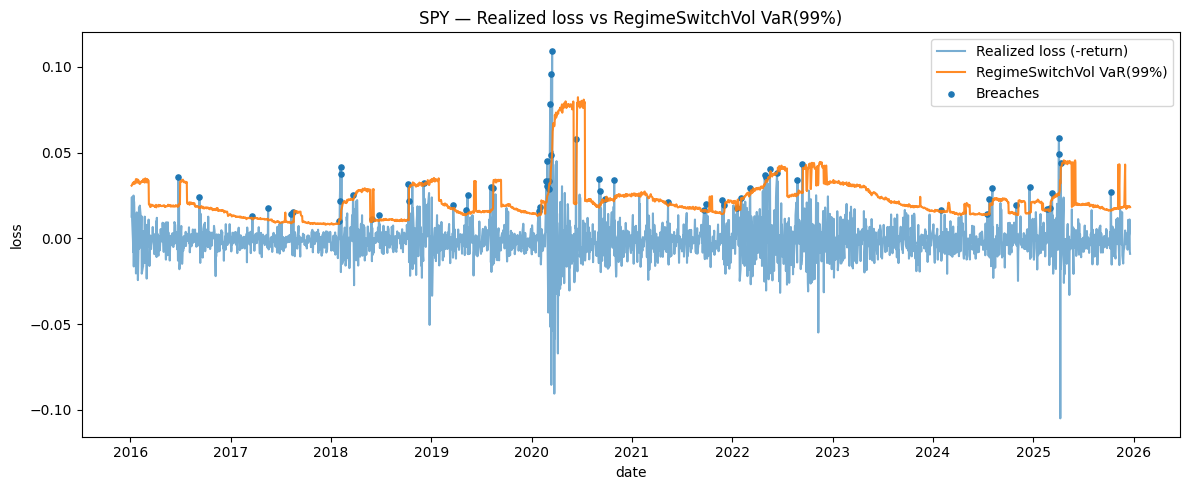

In [19]:
#SPY VaR 99% (Regime Switching)
plot_realized_vs_var(rs_all, "SPY", 99, model_name="RegimeSwitchVol")


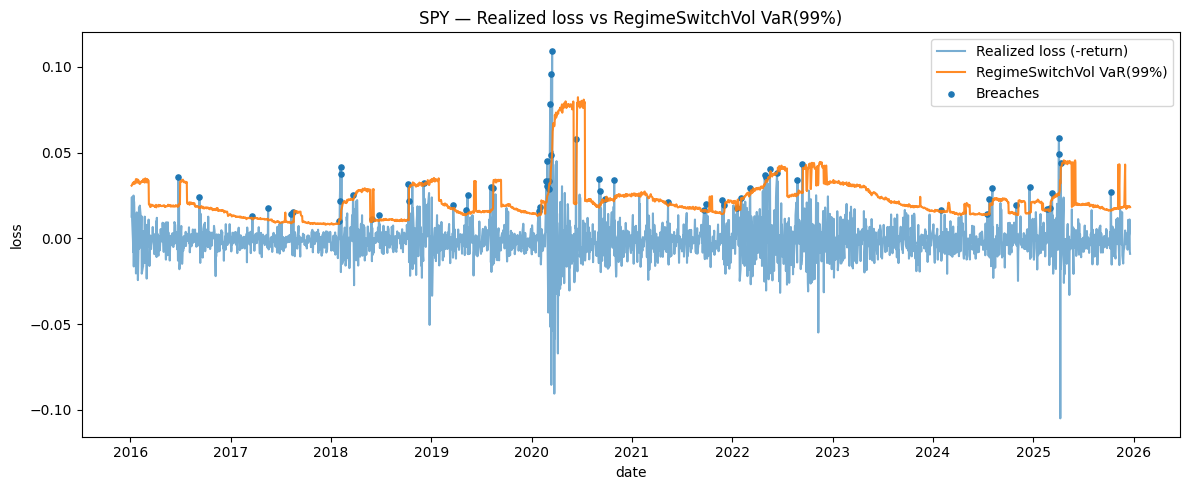

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_RS_VaR99_realized_vs_var.png


In [20]:
def save_realized_vs_var(bt_df: pd.DataFrame, ticker: str, level: int, outpath: Path, model_name="RegimeSwitchVol"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    plt.plot(sub["date"], sub["realized_loss"], label="Realized loss (-return)", alpha=0.6)
    plt.plot(sub["date"], sub[f"VaR_{level}"], label=f"{model_name} VaR({level}%)", alpha=0.9)

    breaches = sub[sub[f"breach_{level}"]]
    plt.scatter(breaches["date"], breaches["realized_loss"], s=14, label="Breaches")

    plt.title(f"{ticker} — Realized loss vs {model_name} VaR({level}%)")
    plt.xlabel("date")
    plt.ylabel("loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

fig_path = DIRS["figures"] / "SPY_RS_VaR99_realized_vs_var.png"
save_realized_vs_var(rs_all, "SPY", 99, fig_path, model_name="RegimeSwitchVol")


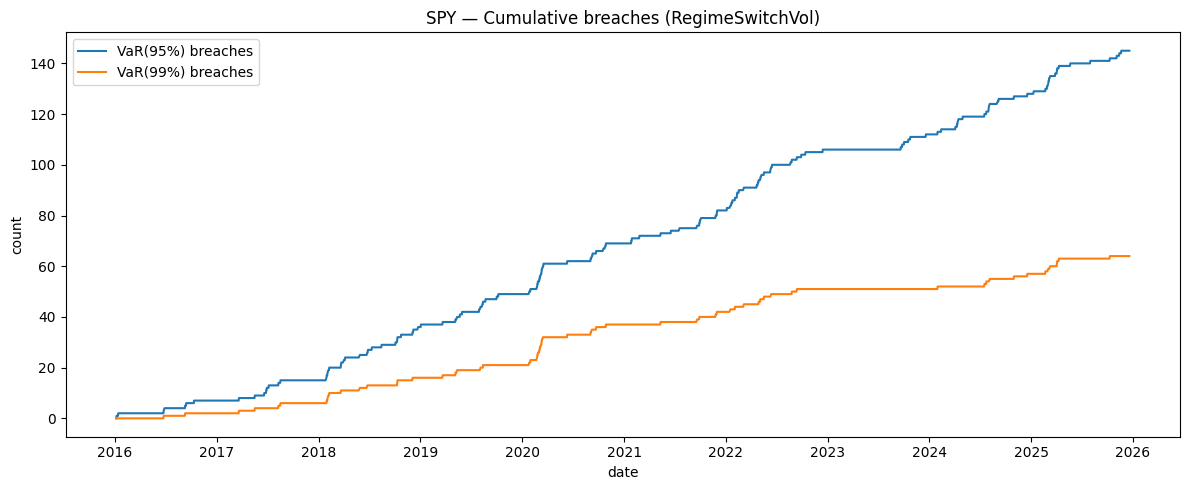

In [21]:
#Cumulative breaches plot
def plot_cumulative_breaches(bt_df: pd.DataFrame, ticker: str, var_levels=(0.95, 0.99), model_name="RegimeSwitchVol"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in var_levels:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches ({model_name})")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_cumulative_breaches(rs_all, "SPY", var_levels=VAR_LEVELS, model_name="RegimeSwitchVol")


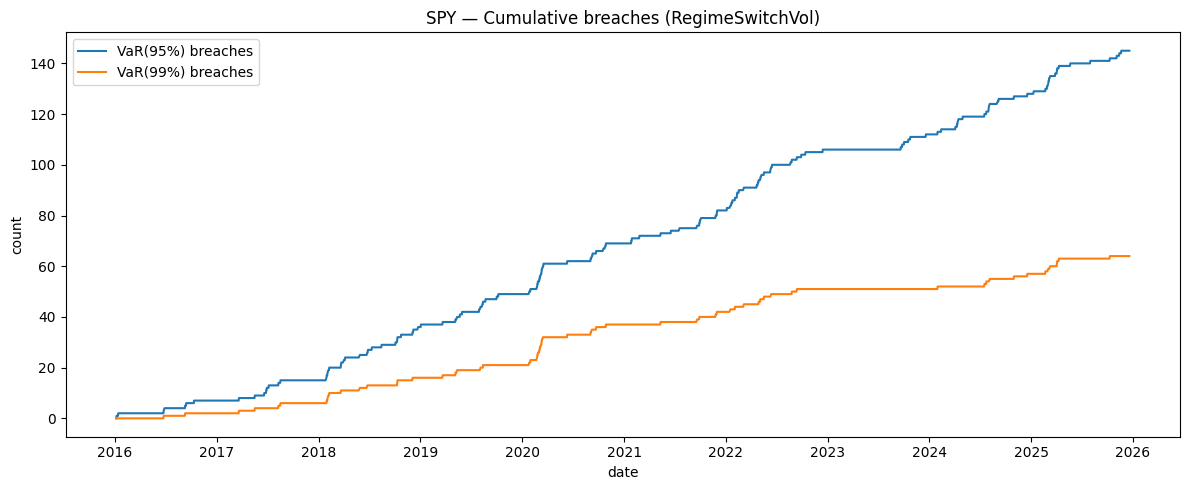

Saved figure: /content/drive/MyDrive/equity_var_backtesting/outputs/figures/SPY_RS_cumulative_breaches.png


In [22]:
def save_cumulative_breaches(bt_df: pd.DataFrame, ticker: str, outpath: Path, var_levels=(0.95, 0.99), model_name="RegimeSwitchVol"):
    sub = bt_df[bt_df["ticker"] == ticker].sort_values("date").copy()
    sub["date"] = pd.to_datetime(sub["date"])

    plt.figure(figsize=(12, 5))
    for a in var_levels:
        lvl = int(a * 100)
        plt.plot(sub["date"], sub[f"breach_{lvl}"].cumsum(), label=f"VaR({lvl}%) breaches")
    plt.title(f"{ticker} — Cumulative breaches ({model_name})")
    plt.xlabel("date")
    plt.ylabel("count")
    plt.legend()
    plt.tight_layout()
    plt.savefig(outpath, dpi=200)
    plt.show()
    print("Saved figure:", outpath)

cum_path = DIRS["figures"] / "SPY_RS_cumulative_breaches.png"
save_cumulative_breaches(rs_all, "SPY", cum_path, var_levels=VAR_LEVELS, model_name="RegimeSwitchVol")
